In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

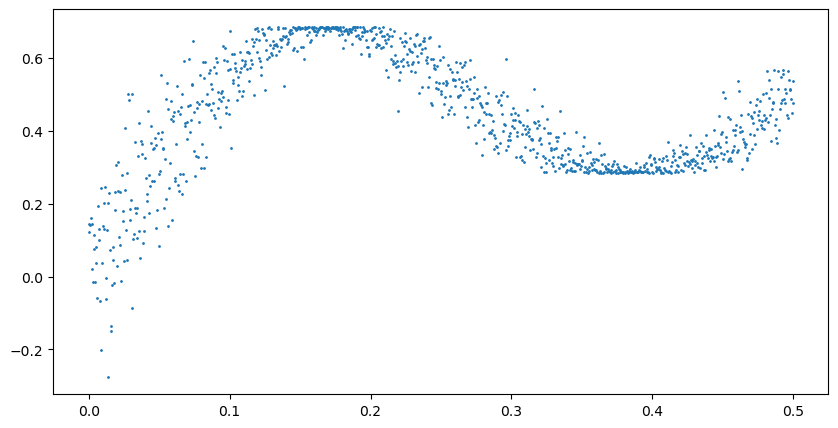

In [3]:
x = np.linspace(0, 0.5, 1000)
ε = 0.02 * np.random.randn(x.shape[0])
y = x + 0.3 * np.sin(2 * np.pi * (x + ε)) + 0.3 * np.sin(4 * np.pi * (x + ε)) + ε

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, 'o', markersize=1);

In [3]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class Model(PyroModule):
    def __init__(self, h1=20, h2=20):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](1, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, 1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu

In [6]:
model = Model()
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(20000)
x_train = torch.from_numpy(x).float()
y_train = torch.from_numpy(y).float()
for epoch in bar:
    loss = svi.step(x_train, y_train)
    bar.set_postfix(loss=f'{loss / x.shape[0]:.3f}')

100%|█████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:33<00:00, 93.55it/s, loss=-1.138]


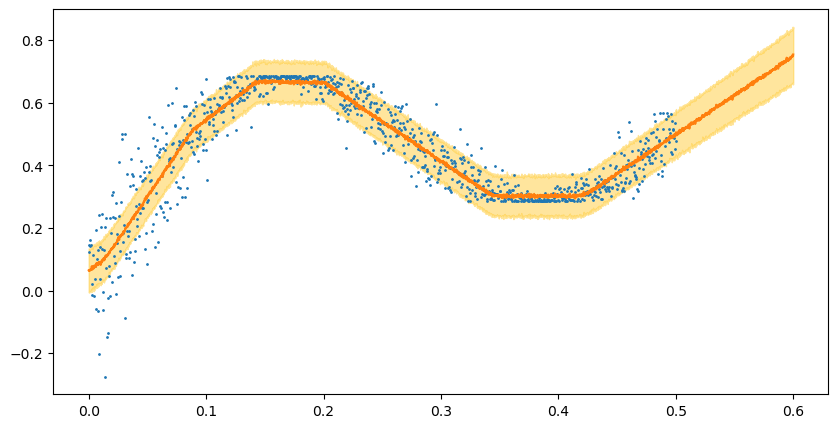

In [8]:
predictive = Predictive(model, guide=guide, num_samples=500)
x_test = torch.linspace(0., 0.6, 3000)
preds = predictive(x_test)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, 'o', markersize=1)
ax.plot(x_test, y_pred)
ax.fill_between(x_test, y_pred - y_std, y_pred + y_std,
                alpha=0.5, color='#ffcd3c');

In [19]:
dist.Normal(loc=torch.zeros([4,2]), scale=torch.ones([4,2])).to_event

<bound method TorchDistributionMixin.to_event of Normal(loc: torch.Size([4, 2]), scale: torch.Size([4, 2]))>

In [21]:
dist.Normal(loc=torch.zeros([4,2]), scale=torch.ones([4,2])).to_event(torch.zeros([4,2]).dim())

Independent(Normal(loc: torch.Size([4, 2]), scale: torch.Size([4, 2])), 2)

In [22]:
torch.zeros([4,2]).dim()

2